min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 15
y_width: 15
---------------------the  1 th iter-------------------------
current weight: 11.0 | current path dist: 93.63961030678928 | time cost: 0.0011248588562011719
SPath dist: 93.63961030678928 | min f in open: 72.26812023536854 | SPath dist/min_f 1.2957250029724916
----------------------------------------------------
---------------------the  2 th iter-------------------------
current weight: 1.1957250029724915 | current path dist: 89.49747468305833 | time cost: 0.004508018493652344
SPath dist: 89.49747468305833 | min f in open: 72.26812023536854 | SPath dist/min_f 1.238408780961451
----------------------------------------------------
---------------------the  3 th iter-------------------------
current weight: 1.0957250029724914 | current path dist: 89.49747468305833 | time cost: 0.0023050308227539062
SPath dist: 89.49747468305833 | min f in open: 74.03124237432849 | SPath dist/min_f 1.208914936622663
--------------------------

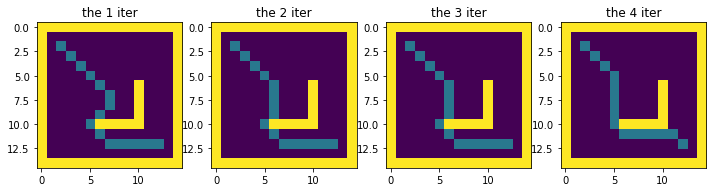

In [6]:
import heapq
import math
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
%matplotlib inline
#set up matplotlib
# is_ipython = 'inline' in matplotlib.get_backend()
# if is_ipython:
#     from IPython import display
# plt.ion()
# plt.figure(figsize=(12, 12))
fig = plt.figure(figsize=(12, 3))

"""

"""

class GridMap:
    def __init__(self, ox, oy, resolution):
        self.min_x = None
        self.min_y = None
        self.max_x = None
        self.max_y = None
        self.x_width = None
        self.y_width = None
        self.obstacle_map = None
        
        self.resolution = resolution
        self.calc_obstacle_map(ox, oy)
        
    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)+1
        self.y_width = round((self.max_y - self.min_y) / self.resolution)+1
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = np.zeros((self.x_width, self.y_width))
        for x, y in zip(ox, oy):
            ix, iy = self.calc_xy_index(x, self.min_x), self.calc_xy_index(y, self.min_y)
            if 0<=ix<self.x_width and 0<=iy<self.y_width:
                self.obstacle_map[ix, iy] = 10.0  
        

    def calc_position(self, index, minp):
        pos = index * self.resolution + minp
        return pos

    def calc_xy_index(self, position, minp):
        return round((position - minp) / self.resolution)
    
    def calc_unique_index(self, node):
        return node.iy*self.x_width + node.ix

    def verify_node(self, node):
        if node.ix >= self.x_width or node.ix < 0 or node.iy >= self.y_width or node.iy < 0:
            return False
        if abs(self.obstacle_map[node.ix, node.iy] - 10.0) < 0.01:
            return False        
        return True

sx = -5.0  # [m]
sy = -5.0  # [m]
gx = 50.0  # [m]
gy = 50.0  # [m]
grid_size = 5.0  # [m]
robot_radius = 1.0  # [m]

# set obstacle positions
ox, oy = [], []
for i in range(-10, 60):
    ox.append(i)
    oy.append(-10.0)
for i in range(-10, 60):
    ox.append(60.0)
    oy.append(i)
for i in range(-10, 61):
    ox.append(i)
    oy.append(60.0)
for i in range(-10, 61):
    ox.append(-10.0)
    oy.append(i)
# for i in range(-10, 40):
#     ox.append(20.0)
#     oy.append(i)
for i in range(20, 40):
    ox.append(40.0)
    oy.append(60.0 - i)    
    
for i in range(20, 40):
    oy.append(40.0)
    ox.append(i)      
grid_map = GridMap(ox, oy, grid_size)



class Node:
    def __init__(self, ix, iy, C=0.0, P=None):
        self.ix = ix
        self.iy = iy
        self.C = C
        self.P = P
        
action_set = {'UP':[0, 1], 'DOWN':[0, -1], 'LEFT':[-1, 0], 'RIGHT':[1, 0], 'UL':[-1, 1], 'UR':[1, 1], 'DL':[-1, -1], 'DR':[1, -1]}

def get_neighbors(current, grid_map):
    for a in action_set:
        l_x1_x2 = np.sqrt(action_set[a][0]*action_set[a][0]+action_set[a][1]*action_set[a][1])*grid_map.resolution
        node = Node(current.ix+action_set[a][0], 
                    current.iy+action_set[a][1], current.C+l_x1_x2, 
                    grid_map.calc_unique_index(current))
        if grid_map.verify_node(node):
            yield node

            
def get_weight(d):
    return np.exp(0.3*d)

def get_heuristic(node, end_node, w):
    dx = node.ix - end_node.ix
    dy = node.iy - end_node.iy
    d = np.sqrt(dx*dx+dy*dy)*grid_map.resolution
    return d*w

def AnytimeAStarOnce(w, pre_path_dist, grid_map, end_node):
    Closed_set = {}
    InCons_set = {}    
    while True:
#         print(len(Open_set))
        if not Open_set:
            path_x, path_y, path_dist = ShortestPathFinder(grid_map, end_node)
            return InCons_set, path_x, path_y, path_dist   
        F, c_id = heapq.heappop(Q)
        if c_id in Open_set:                
            current = Open_set.pop(c_id)
            Closed_set[c_id] = current
            if current.ix == end_node.ix and current.iy == end_node.iy:                
                path_x, path_y, path_dist = ShortestPathFinder(grid_map, end_node)
                return InCons_set, path_x, path_y, path_dist
            for node in get_neighbors(current, grid_map):
                neighbor_index = grid_map.calc_unique_index(node)
                if neighbor_index not in Visited_set:
                    Visited_set[neighbor_index] = node 
                    Open_set[neighbor_index] = node 
                    heapq.heappush(Q, (node.C+get_heuristic(node, end_node, w), neighbor_index))
#                     grid_map.obstacle_map[node.ix, node.iy] = 2  
                elif (pre_path_dist > node.C+get_heuristic(node, end_node, 1.0) and 
                      Visited_set[neighbor_index].C > node.C):
                    Visited_set[neighbor_index] = node 
                    if neighbor_index not in Closed_set:
                        Open_set[neighbor_index] = node
                        heapq.heappush(Q, (node.C+get_heuristic(node, end_node, w), neighbor_index))
#                         grid_map.obstacle_map[node.ix, node.iy] = 2
                    else:
                        InCons_set[neighbor_index] = node

#         plt.clf()
#         plt.imshow(grid_map.obstacle_map)
#         if is_ipython:
#             display.clear_output(wait=True)
#             display.display(plt.gcf())                
                
        
Visited_set = {} 
Open_set = {}
Q = []

import time
    
def AnytimeAStar(grid_map, start_node, end_node, T): # 允许的计算周期 unit 秒 
    w = 11.1
    Visited_set[grid_map.calc_unique_index(start_node)] = start_node
    Open_set[grid_map.calc_unique_index(start_node)] = start_node
    heapq.heappush(Q, (start_node.C+get_heuristic(start_node, end_node, w), 
                       grid_map.calc_unique_index(start_node)))
    SPath_dist = 99999.0
    t0 = time.time()
    dt = 0.0
    count = 1
    while w >= 1.0 and dt < T: 
        w -= 0.1
        print("---------------------the ",count,"th iter-------------------------")
        t1 = time.time()
        InCons_set, SPathx, SPathy, SPath_dist = AnytimeAStarOnce(w, SPath_dist, grid_map, end_node)
        dt = time.time()-t0 # unit s
        print("current weight:", w, "| current path dist:",SPath_dist, "| time cost:", time.time()-t1);
        for index, node in InCons_set.items():
            Open_set[index] = node
            heapq.heappush(Q, (node.C+get_heuristic(node, end_node, w), index))
        min_f = min([n.C+get_heuristic(n, end_node, 1.0) for _, n in Open_set.items()])
        w = min(w, SPath_dist/min_f)
        print("SPath dist:", SPath_dist, "| min f in open:", min_f, "| SPath dist/min_f", SPath_dist/min_f)
        
        
        print("----------------------------------------------------")
        for ix, iy in zip(SPathx, SPathy):
            grid_map.obstacle_map[ix, iy] = 4
        plt.subplot(1,4,count)
        plt.imshow(grid_map.obstacle_map)  
        plt.title("the "+str(count)+" iter")
        grid_map.obstacle_map[start_node.ix, start_node.iy] = 8
        grid_map.obstacle_map[end_node.ix, end_node.iy] = 3        
        for ix, iy in zip(SPathx, SPathy):
            grid_map.obstacle_map[ix, iy] = 0
        count += 1    
    print("Anytime A* Finished.")
    return SPathx, SPathy, SPath_dist    
            
        
def ShortestPathFinder(grid_map, end_node):
    if grid_map.verify_node(end_node) == False:
        print("the goal is unreachable!!!please change a reachable goal...")
        return [], [], -1
    
    end_index = grid_map.calc_unique_index(end_node)
    SPath_x = [Visited_set[end_index].ix]
    SPath_y = [Visited_set[end_index].iy]      
    SPath_dist = Visited_set[end_index].C
    v_index = Visited_set[end_index].P
    while v_index: 
        SPath_x.append(Visited_set[v_index].ix)
        SPath_y.append(Visited_set[v_index].iy)
        v_index = Visited_set[v_index].P
    return list(reversed(SPath_x)), list(reversed(SPath_y)), SPath_dist

start_node = Node(2, 2)
end_node = Node(12, 12)
grid_map.obstacle_map[start_node.ix, start_node.iy] = 8
grid_map.obstacle_map[end_node.ix, end_node.iy] = 3
plt.imshow(grid_map.obstacle_map)
T = 1.0 # 系统给的时间周期为100ms
path_x, path_y, path_dist = AnytimeAStar(grid_map, start_node, end_node,T)
# grid_map.obstacle_map[end_node.ix, end_node.iy] = 4

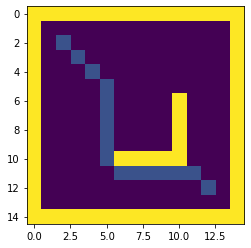

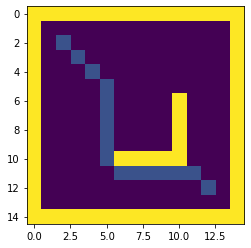

In [27]:
for ix, iy in zip(path_x, path_y):
    grid_map.obstacle_map[ix, iy] = 4
    
plt.clf()
plt.imshow(grid_map.obstacle_map)
if is_ipython:
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    

In [2]:
import heapq

a = [(7,2),(3,5),(4,5),(3,2)]
heapq.heapify(a)
a[0]

(3, 2)

In [28]:
min([2,3,4,5])

2

In [5]:
a = [0]
if a:
    print("ok")

ok


In [14]:
if [1,2]>[1,1]:
    print("ok")

ok


In [16]:
a = {'a': 1, 'b':2, 'c':3}
del a['a']
print(a)

{'b': 2, 'c': 3}
